# Data Analysis - Covid-19

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import mplfinance as mpf
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf # Connects Plotly to Pandas
# Makes Plotly work in your Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import requests # Get URL data
from bs4 import BeautifulSoup # Manipulate URL data
import json
from pandas import DataFrame as df

In [2]:
#pip install mplfinance

# Grab Data from a URL

In [5]:
# Grab all data from URL
web_page = requests.get("https://www.worldometers.info/coronavirus")
soup = BeautifulSoup(web_page.text, 'html.parser')
#print(soup.prettify()) # Get source from site

## Basic Covid Data

In [6]:
# using web developr view to find the specific number values and which html tags to search for
# for this website the numeric values are under the <div class="maincounter-number">

# Find basic data in div with class name maincounter-number
covid_data = soup.find_all("div", class_ = "maincounter-number")
# 
print("Coronavirus Cases: ", covid_data[0].text.strip())
print("Deaths: ", covid_data[1].text.strip())
print("Recovered: ", covid_data[2].text.strip())

# If I wanted world data I could search for script tags with type
# set as text/javascript
data = soup.find_all("script", {"type":"text/javascript"})
# for content in data:
#     print(content)

Coronavirus Cases:  45,120,686
Deaths:  1,183,372
Recovered:  32,858,493


In [10]:
# further inspection of the source code, the world covid data is in <div class="main_table_countries"> or table with same name

# Search for table with id main_table_countries_today
results = soup.find(id='main_table_countries_today')
# Print all tds
content = results.find_all('td')
#content

In [11]:
clean_data = ""
# Use a different separator since the commas cause confusion
for data in content:
    clean_data += data.text.strip() + "|"
# Get rid of pluses
clean_data = clean_data.replace("+", "")
# Get rid of N/A
clean_data = clean_data.replace("N/A", "0")
clean_data

'|North America|10,956,571|45,913|348,757|999|7,281,323|17,412|3,326,491|20,597||||||North America|||||Asia|13,480,849|75,072|239,911|1,227|11,941,022|65,461|1,299,916|21,290||||||Asia|||||South America|9,530,345|6,802|291,672|251|8,507,549|1,550|731,124|18,214||||||South America|||||Europe|9,348,072|218,923|259,745|2,245|3,653,864|48,931|5,434,463|19,757||||||Europe|||||Africa|1,766,691|6,980|42,302|84|1,441,535|5,073|282,854|2,238||||||Africa|||||Oceania|37,437|19|970||32,541|13|3,926|25||||||Australia/Oceania||||||721||15||659||47|4|||||||||||World|45,120,686|353,709|1,183,372|4,806|32,858,493|138,440|11,078,821|82,125|5,789|151.8||||All||||1|USA|9,157,382|36,631|233,552|422|5,943,303|10,091|2,980,527|16,870|27,613|704|140,588,649|423,923|331,637,477|North America|36|1,420|2|2|India|8,071,963|33,198|120,913|350|7,348,950|33,999|602,100|8,944|5,831|87|106,563,440|76,973|1,384,419,342|Asia|172|11,450|13|3|Brazil|5,474,840|5,085|158,611|143|4,934,548||381,681|8,318|25,697|744|21,900,00

## Use Regular Express (Regex) to clean data

In [15]:
import re

# Got a list of countries from the website
countries = [
    'usa', 'spain', 'italy', 'france', 'germany', 'uk', 'turkey', 'iran', 
    'russia', 'brazil', 'canada', 'belgium', 'netherlands', 'switzerland', 
    'india', 'peru', 'portugal', 'ecuador', 'ireland', 'sweden', 'saudi-arabia', 
    'israel', 'austria', 'mexico', 'singapore', 'japan', 'chile', 'pakistan', 
    'poland', 'romania', 'belarus', 'qatar', 'south-korea', 'united-arab-emirates', 
    'indonesia', 'ukraine', 'denmark', 'serbia', 'philippines', 'norway', 
    'czech-republic', 'australia', 'dominican-republic', 'bangladesh', 'malaysia', 
    'panama', 'colombia', 'finland', 'south-africa', 'egypt', 'morocco', 'argentina', 
    'luxembourg', 'moldova', 'algeria', 'kuwait', 'thailand', 'kazakhstan', 
    'bahrain', 'hungary', 'greece', 'oman', 'croatia', 'uzbekistan', 'iraq', 
    'armenia', 'iceland', 'afghanistan', 'estonia', 'azerbaijan', 'cameroon', 
    'bosnia-and-herzegovina', 'ghana', 'new-zealand', 'lithuania', 'slovenia', 
    'macedonia', 'slovakia', 'cuba', 'bulgaria', 'nigeria', 'cote-d-ivoire', 
    'china-hong-kong-sar', 'djibouti', 'guinea', 'bolivia', 'tunisia', 'latvia', 
    'cyprus', 'andorra', 'albania', 'lebanon', 'niger', 'kyrgyzstan', 'costa-rica', 
    'senegal', 'honduras', 'burkina-faso', 'uruguay', 'sri-lanka', 'san-marino', 
    'channel-islands', 'guatemala', 'georgia', 'democratic-republic-of-the-congo', 
    'malta', 'jordan', 'somalia', 'taiwan', 'reunion', 'mayotte', 'mali', 'kenya', 
    'jamaica', 'state-of-palestine', 'mauritius', 'venezuela', 'el-salvador', 
    'montenegro', 'isle-of-man', 'tanzania', 'viet-nam', 'equatorial-guinea', 
    'sudan', 'paraguay', 'maldives', 'congo', 'rwanda', 'faeroe-islands', 'gabon', 
    'martinique', 'guadeloupe', 'myanmar', 'gibraltar', 'brunei-darussalam', 
    'liberia', 'ethiopia', 'madagascar', 'cambodia', 'trinidad-and-tobago', 
    'french-guiana', 'bermuda', 'cabo-verde', 'aruba', 'togo', 'monaco', 
    'sierra-leone', 'zambia', 'liechtenstein', 'bahamas', 'barbados', 'uganda', 
    'mozambique', 'sint-maarten', 'guyana', 'haiti', 'cayman-islands', 'benin', 
    'libya', 'swaziland', 'french-polynesia', 'guinea-bissau', 'nepal', 'chad', 
    'china-macao-sar', 'syria', 'eritrea', 'saint-martin', 'mongolia', 'malawi', 
    'zimbabwe', 'angola', 'antigua-and-barbuda', 'timor-leste', 'botswana', 
    'central-african-republic', 'laos', 'belize', 'fiji', 'grenada', 'new-caledonia', 
    'curacao', 'dominica', 'namibia', 'saint-kitts-and-nevis', 'saint-lucia', 
    'saint-vincent-and-the-grenadines', 'nicaragua', 'falkland-islands-malvinas', 
    'burundi', 'montserrat', 'turks-and-caicos-islands', 'greenland', 'seychelles', 
    'gambia', 'suriname', 'holy-see', 'papua-new-guinea', 'mauritania', 'bhutan', 
    'british-virgin-islands', 'saint-barthelemy', 'south-sudan', 'western-sahara', 
    'caribbean-netherlands', 'sao-tome-and-principe', 'anguilla', 'saint-pierre-and-miquelon', 
    'yemen', 'china'
]

# Cycle through countries
for c in countries:
    # Add country name plus look for all , | and any numbers that follow
    pattern = c+"[,|\d]*"
    # Search for the pattern and ignore case so I don't have to worry about
    # country capitalization
    data = re.search(pattern, clean_data, re.IGNORECASE)
    # If data is a NoneType ignore it
    if data is not None:
        print(data.group())


USA|9,157,382|36,631|233,552|422|5,943,303|10,091|2,980,527|16,870|27,613|704|140,588,649|423,923|331,637,477|
Spain|1,238,922|23,580|35,639|173|0|0|0|2,404|26,495|762|16,690,076|356,925|46,760,741|
Italy|616,595|26,831|38,122|217|279,282|3,878|299,191|1,651|10,203|631|15,353,490|254,060|60,432,485|
France|1,235,132||35,785||113,977||1,085,370|3,045|18,909|548|15,315,055|234,458|65,320,966|
Germany|494,465|14,844|10,413|54|339,200|6,300|144,852|1,696|5,895|124|21,882,967|260,910|83,871,855|
UK|965,340|23,065|45,955|280|0|0|0|957|14,196|676|33,089,838|486,596|68,002,734|
Turkey|370,832|2,319|10,099|72|320,762|1,581|39,971|1,916|4,382|119|13,741,180|162,360|84,634,022|
Iran|596,941|8,293|34,113|399|472,598|4,681|90,230|5,055|7,078|404|4,857,392|57,592|84,341,416|
Russia|1,581,693|17,717|27,301|366|1,186,041|14,740|368,351|2,300|10,837|187|59,284,119|406,181|145,955,066|
Brazil|5,474,840|5,085|158,611|143|4,934,548||381,681|8,318|25,697|744|21,900,000|102,791|213,052,818|
Canada|227,550|1

## Import CSV Dataset

In [16]:
# Import Our World in Data CSV
# https://github.com/owid/covid-19-data/tree/master/public/data
owid_df = pd.read_csv('owid-covid-data.csv')

owid_df.columns # Show all columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index'],
      dtype='object')

In [18]:
# Create Numpy array of unique countries
country_df = owid_df.location.unique() # to list countries once
country_df # Show countries


array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Bonaire Sint Eustatius and Saba',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of Congo', 'Congo', 'Colombia', 'Comoros',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica',
       'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt',
       'Eritrea', 'Western Sahara', 'Spain', 'Estonia', 'Ethiopia',
       'Finland', 'Fiji', 'Falkland Islands', 'France',

In [19]:
country_df.size # How many countries (214)

214

In [20]:
country_df.shape

(214,)

In [24]:
# Get indexes for location rows equal to Canada
indexer = owid_df[owid_df['location']=='Canada'].index
indexer

Int64Index([8194, 8195, 8196, 8197, 8198, 8199, 8200, 8201, 8202, 8203,
            ...
            8486, 8487, 8488, 8489, 8490, 8491, 8492, 8493, 8494, 8495],
           dtype='int64', length=302)

In [23]:
# Get dataframe location and total cases for Canada
CAN_totalcases = owid_df.loc[indexer, 'date':'total_cases']
CAN_totalcases

,date,total_cases
8194,2019-12-31,NaN
8195,2020-01-01,NaN
8196,2020-01-02,NaN
8197,2020-01-03,NaN
8198,2020-01-04,NaN
...,...,...
8491,2020-10-23,209148.0
8492,2020-10-24,211732.0
8493,2020-10-25,213959.0
8494,2020-10-26,216104.0


In [26]:
# Delete NaN values
CAN_totalcases = CAN_totalcases.dropna()
CAN_totalcases

,date,total_cases
8220,2020-01-26,1.0
8221,2020-01-27,1.0
8222,2020-01-28,2.0
8223,2020-01-29,3.0
8224,2020-01-30,3.0
...,...,...
8491,2020-10-23,209148.0
8492,2020-10-24,211732.0
8493,2020-10-25,213959.0
8494,2020-10-26,216104.0


<AxesSubplot:xlabel='date'>

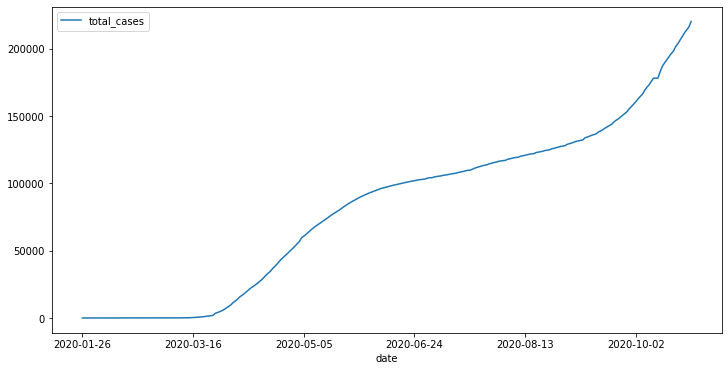

In [27]:
# Set date as index
CAN_totalcases.set_index('date', inplace=True)
CAN_totalcases.plot(figsize=(12,6))

<AxesSubplot:xlabel='date'>

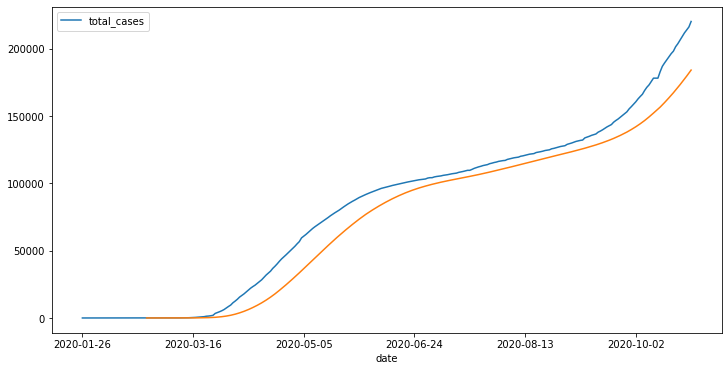

In [29]:
# Plot a 30 day moving average
CAN_totalcases.plot(figsize=(12,6))

# window 30 = month
CAN_totalcases.rolling(window=30).mean()['total_cases'].plot()

# number of cases rising ABOVE the average (orange line) 

## Do covid lockdown restrictions work on reducing number of cases?

Index(['new_cases_per_million'], dtype='object')
Index(['new_cases_per_million'], dtype='object')


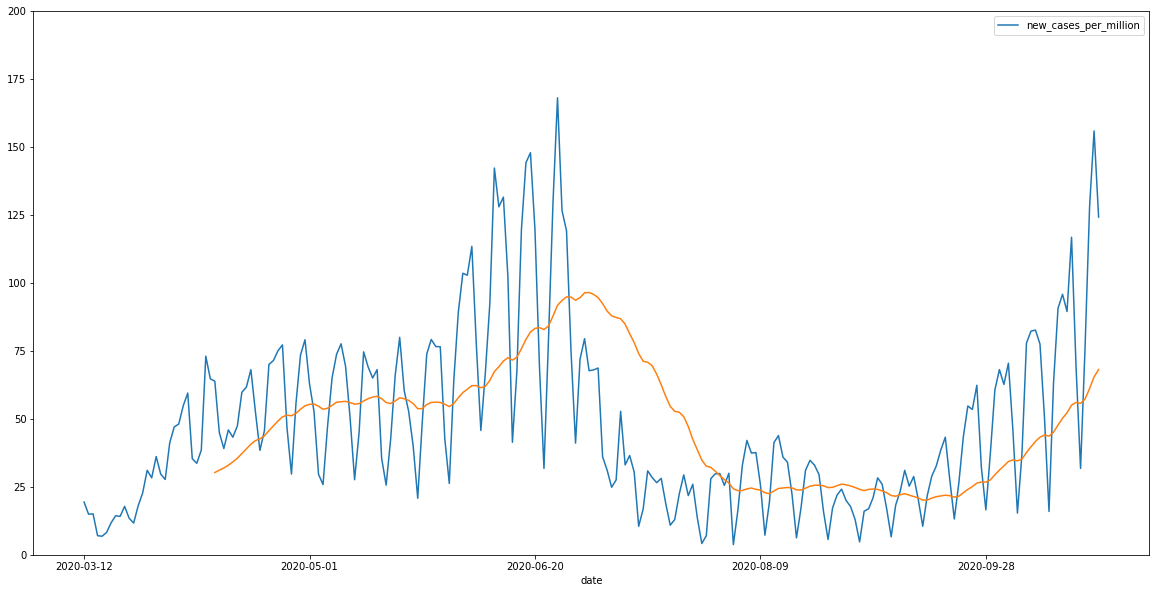

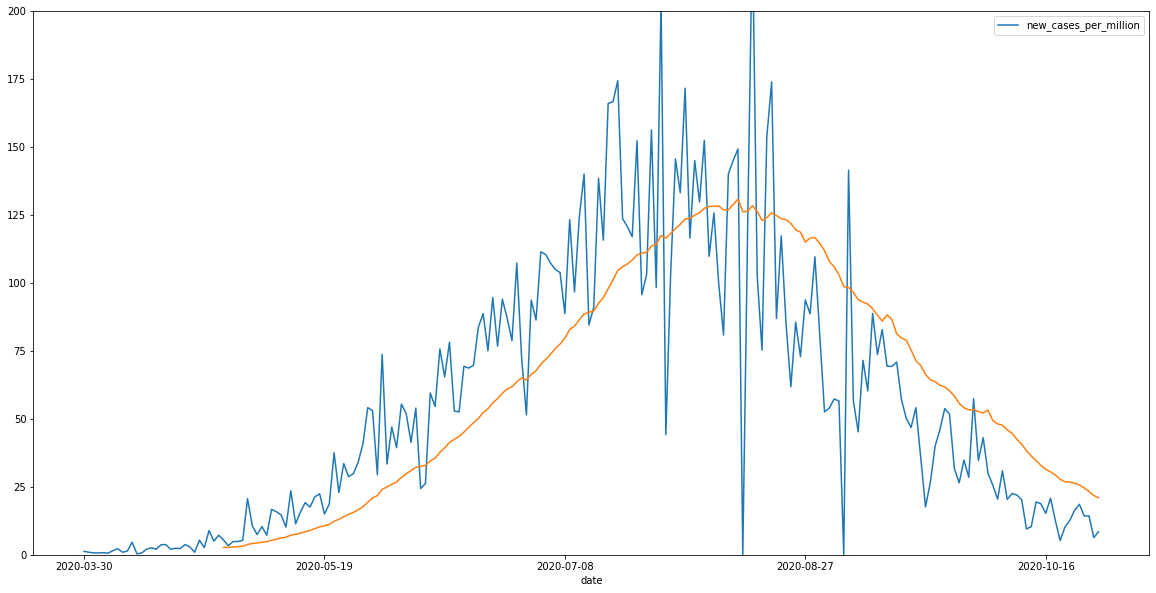

In [31]:
# need to make a function to run through dataset, ma (moving average)

def plot_covid_data(country, col, plot_ma=False, y_max=200):
    
    # Get indexes for location rows equal to country name
    indexer = owid_df[owid_df['location']==country].index
    
    # Get dataframe location and column data for country name
    country_df = owid_df.loc[indexer, 'date':col]
    
    # Delete NaN values
    country_df = country_df.dropna()
    
    # Set date as index
    country_df.set_index('date', inplace=True)
    
    # Remove all columns except for what I want
    country_df.drop(country_df.columns.difference([col]), 1, inplace=True)
    country_df.plot(figsize=(20,10), ylim=[0,y_max])

    # Plot moving average if requested
    if plot_ma:
        # Plot a 30 day moving average
        country_df.rolling(window=30).mean()[col].plot()
    print(country_df.columns)
    
# Least restrictive lockdown
plot_covid_data('Sweden', 'new_cases_per_million', True)
# Most restrictive lockdown measures
plot_covid_data('Bolivia', 'new_cases_per_million', True) 

# owid_df.columns

## How does median age effect the death rate?

Index(['new_deaths_per_million'], dtype='object')
Index(['new_deaths_per_million'], dtype='object')


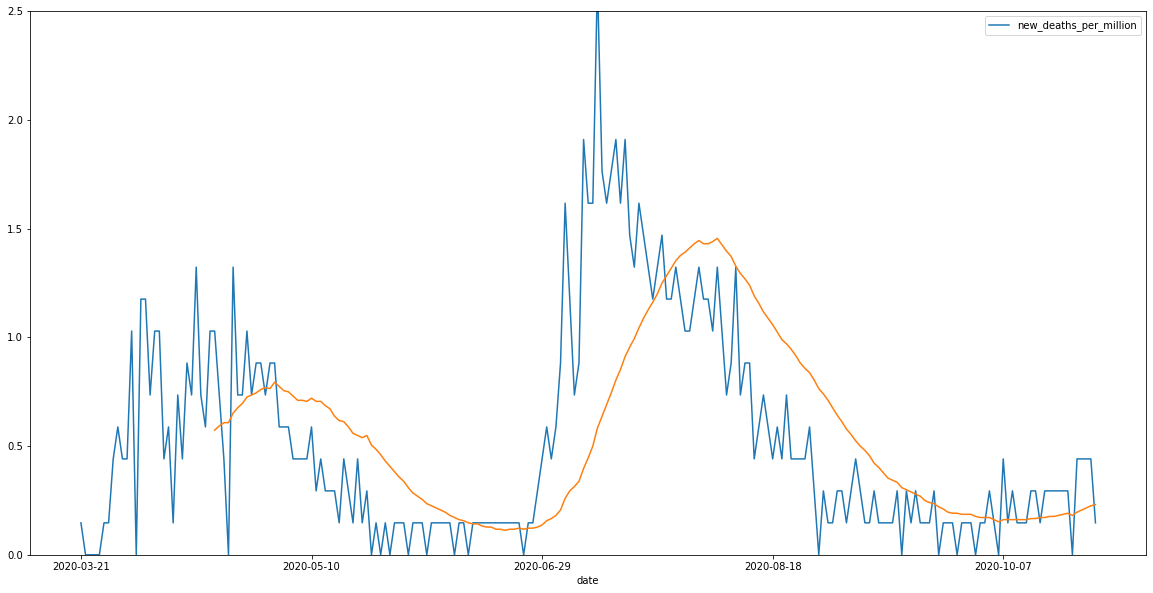

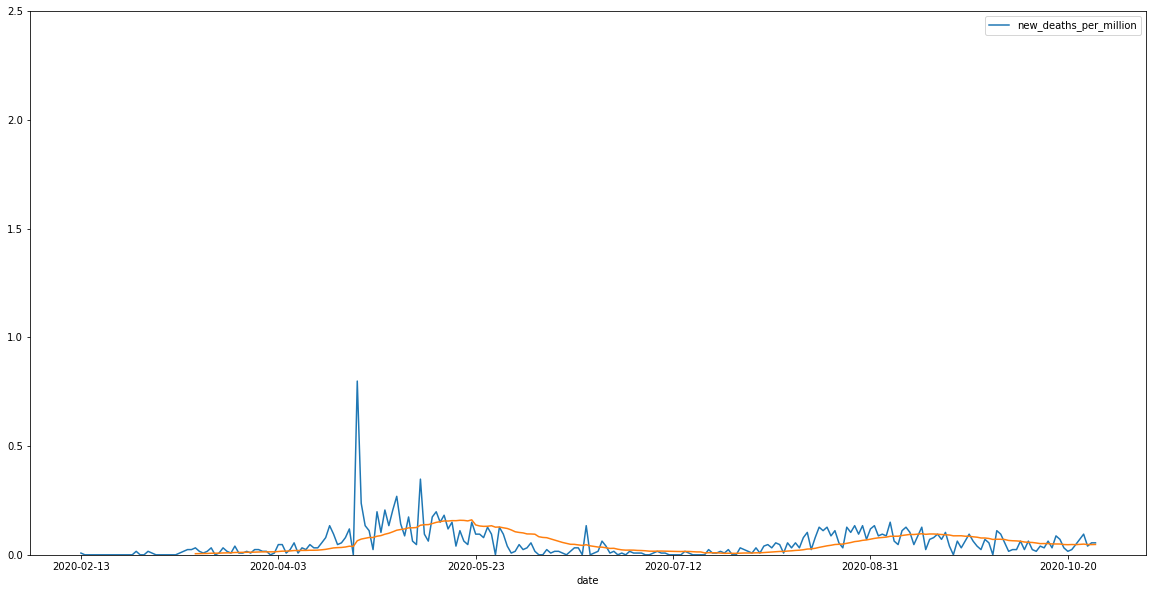

In [32]:
# Country with lowest median age
plot_covid_data('Serbia', 'new_deaths_per_million', True, 2.5)
# Country with highest median age
plot_covid_data('Japan', 'new_deaths_per_million', True, 2.5)

## How does obesidty effect the death rate?

Index(['new_deaths_per_million'], dtype='object')
Index(['new_deaths_per_million'], dtype='object')


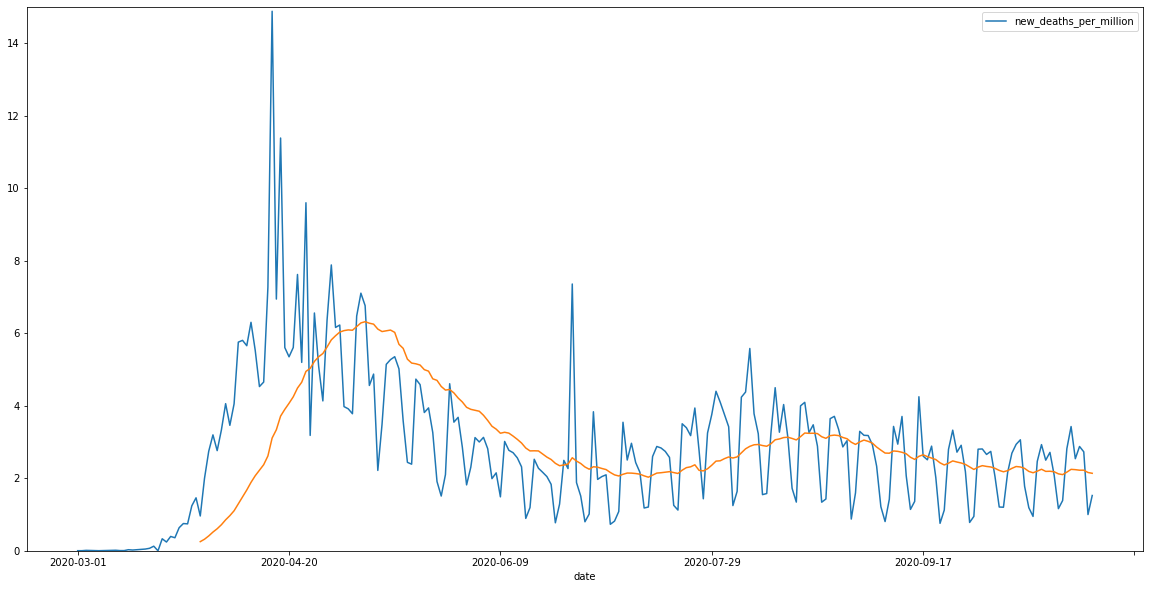

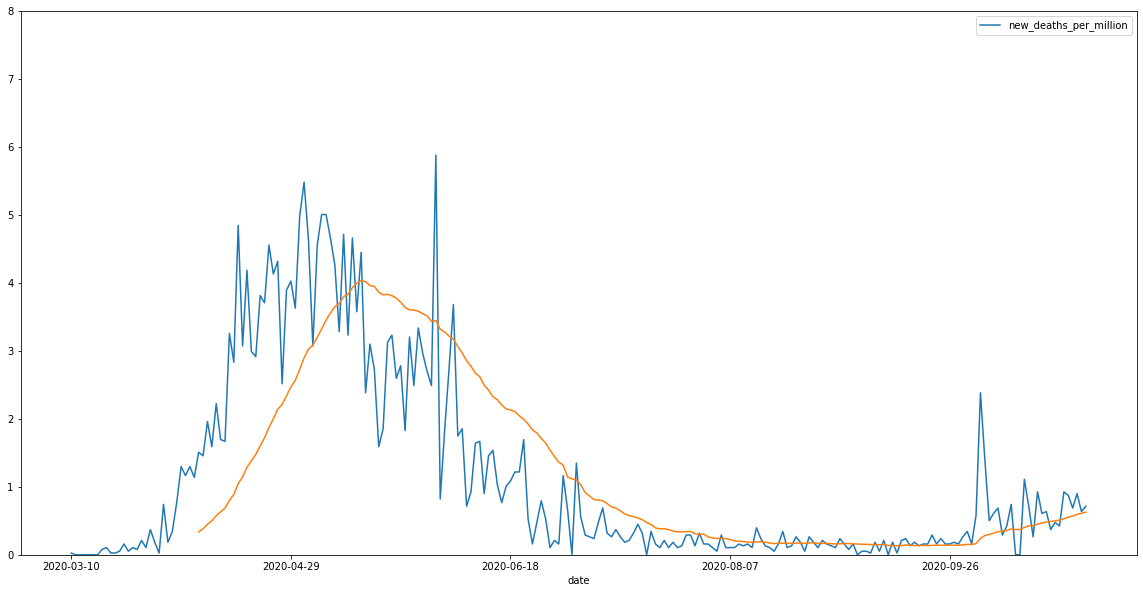

In [42]:
# Countries with highest percentages 
plot_covid_data('United States', 'new_deaths_per_million', True, 15)
plot_covid_data('Canada', 'new_deaths_per_million', True, 8)

Index(['new_deaths_per_million'], dtype='object')
Index(['new_deaths_per_million'], dtype='object')


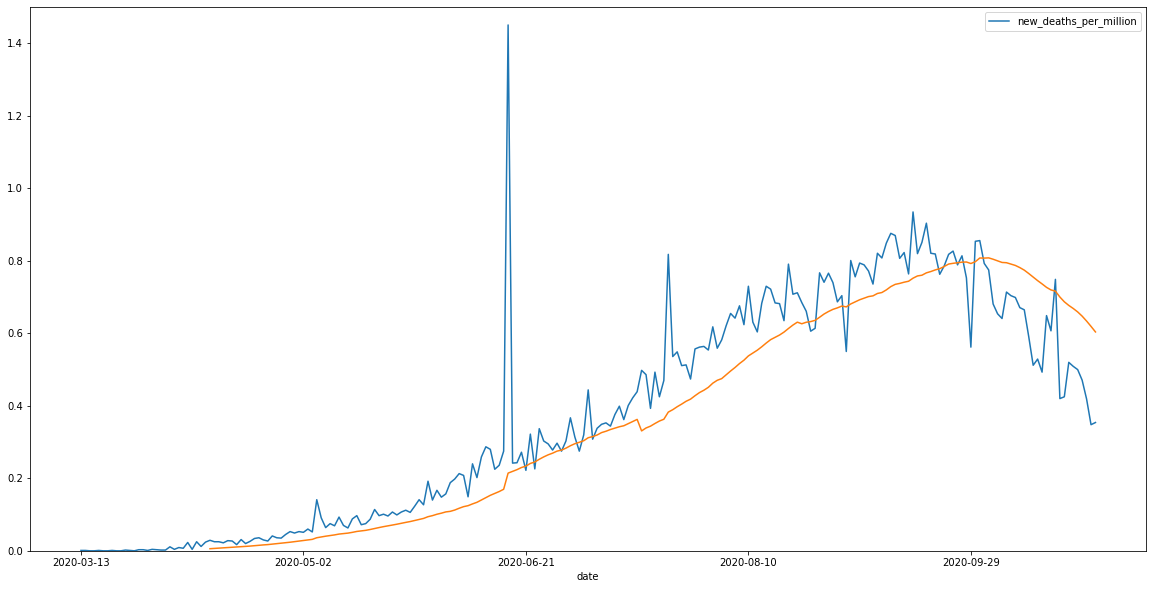

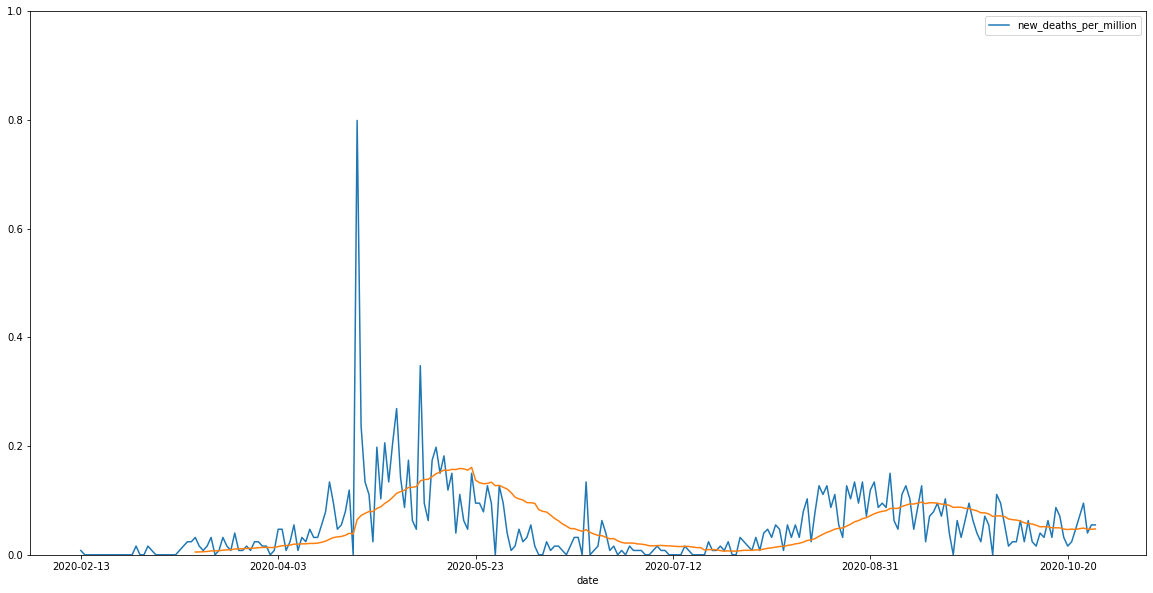

In [40]:
# 2 countries with lowest percentages
plot_covid_data('India', 'new_deaths_per_million', True, 1.5)
plot_covid_data('Japan', 'new_deaths_per_million', True, 1)

## How does diabetes prevalence effect death?

Index(['new_deaths_per_million'], dtype='object')
Index(['new_deaths_per_million'], dtype='object')


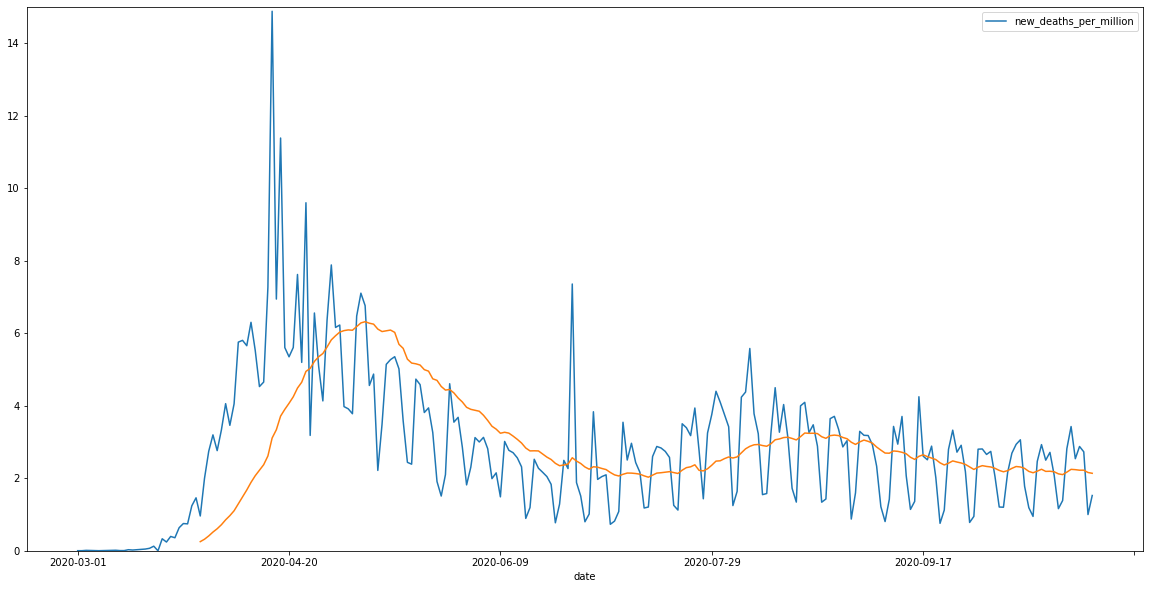

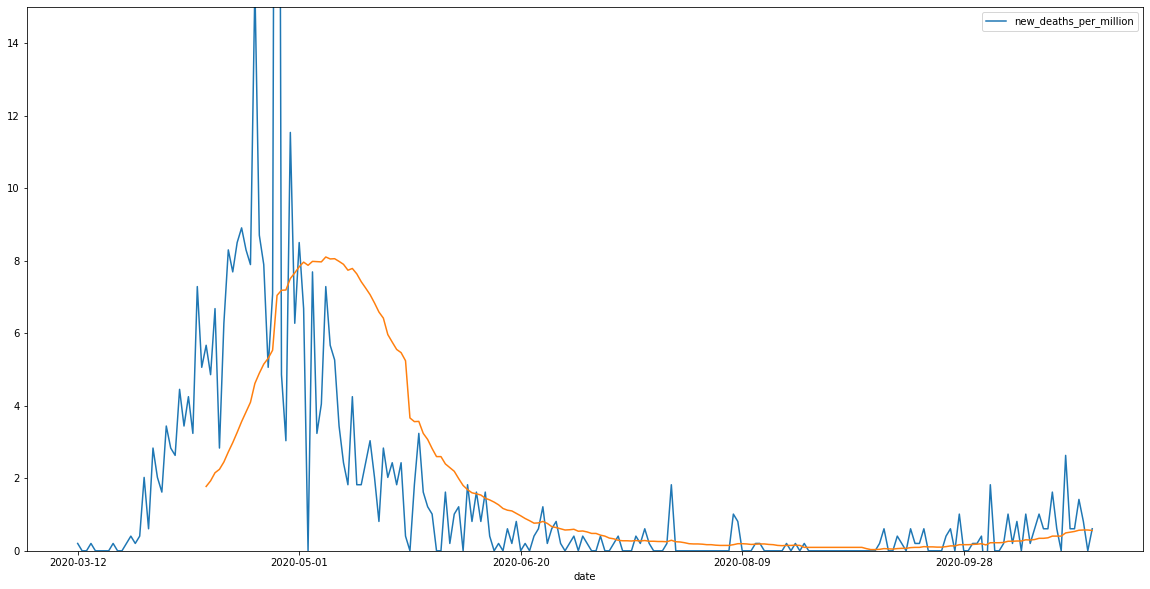

In [43]:
# Country with highest percentage 
plot_covid_data('United States', 'new_deaths_per_million', True, 15)
# Country with lowest percentage
plot_covid_data('Ireland', 'new_deaths_per_million', True, 15)

## does more testing slow the deathrate?

Index(['new_deaths_per_million'], dtype='object')
Index(['new_deaths_per_million'], dtype='object')


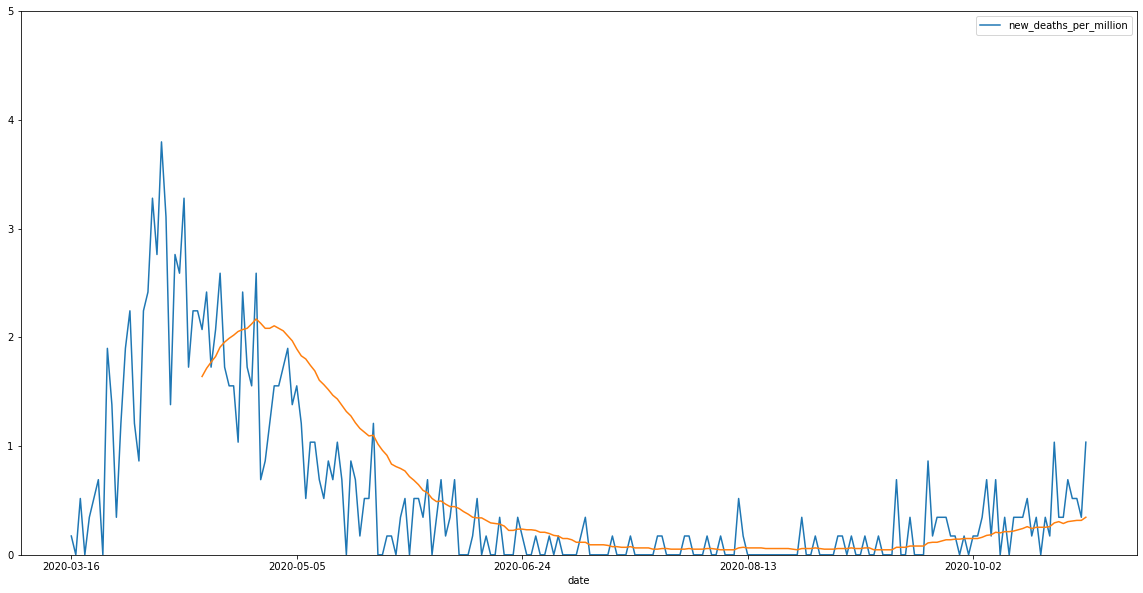

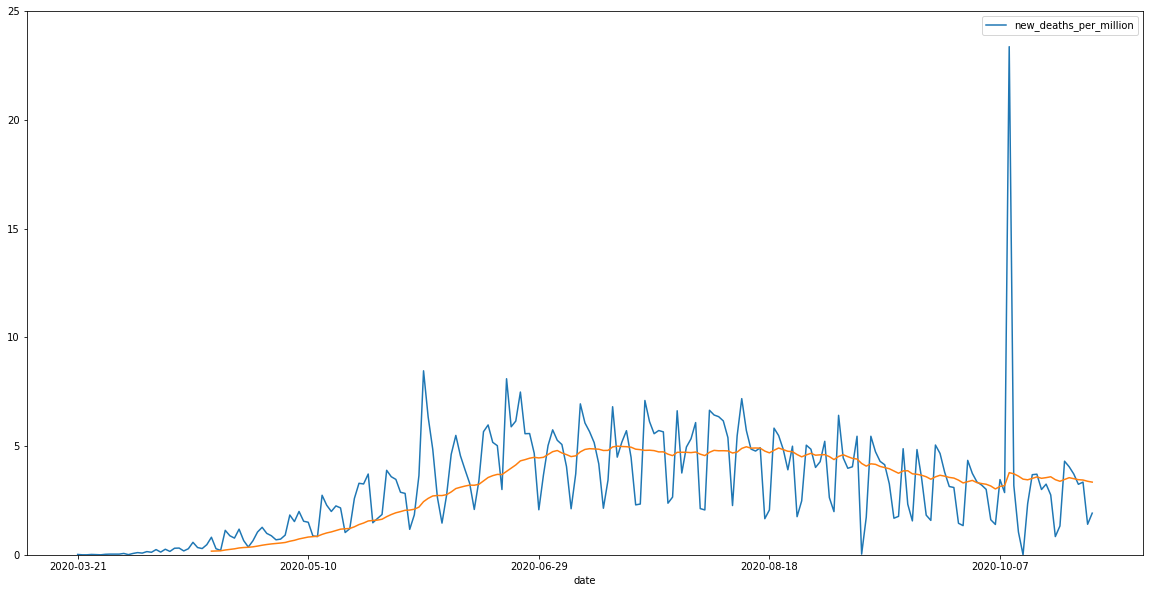

In [49]:
# Country with highest percentage 
plot_covid_data('Denmark', 'new_deaths_per_million', True, 5)
# Country with lowest percentage
plot_covid_data('Mexico', 'new_deaths_per_million', True, 25)

In [50]:
# Receives date and column of interest for every country as a dataframe
def scatter_plot(date, col1, col2):
    tot_df = pd.DataFrame(columns = ['date', 'location', col1, col2])
   # temp_df = pd.DataFrame()
    for c in country_df:
        # Get country specific data and append to main dataframe
        temp_df = owid_df[(owid_df['location']==c) & (owid_df['date']==date)][['date', 'location', col1, col2]]
        tot_df = tot_df.append(temp_df, ignore_index = True).fillna(0)
    tot_df.set_index('date', inplace=True)
    
    # Create Plotly scatter plot
    fig = px.scatter(
        data_frame=tot_df, 
        x=col2, 
        y=col1, 
        color="location", 
        trendline="ols",
        hover_data=['location']
    )
    fig.show()
    
    return tot_df

# Try median_age, aged_70_older, diabetes_prevalence, male_smokers, 
scatter_plot('2020-10-27', 'total_deaths_per_million', 'aged_70_older')


,location,total_deaths_per_million,aged_70_older
date,,,
2020-10-27,Aruba,337.186,7.452
2020-10-27,Afghanistan,39.097,1.337
2020-10-27,Angola,8.154,1.362
2020-10-27,Anguilla,0.000,0.000
2020-10-27,Albania,166.794,8.643
...,...,...,...
2020-10-27,South Africa,320.493,3.053
2020-10-27,Zambia,18.930,1.542
2020-10-27,Zimbabwe,16.282,1.882
